In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import sys
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_bool_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from rfpimp import *
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_confusion_matrix


In [2]:
input_df = sys.argv[1]
majority_fraction = float(sys.argv[2])
approach = sys.argv[3]
n_estimators = int(sys.argv[4])
min_samples_split = int(sys.argv[5])
min_samples_leaf = int(sys.argv[6])
max_features = sys.argv[7]
max_depth = sys.argv[8]
bootstrap = eval(sys.argv[9])

ValueError: could not convert string to float: '--stdin=9008'

In [2]:
input_df = '../gene_info.genes_tes_gc.lengths_effectors.guy11_histone_expression.go_pfam_eccdnas.txt'
majority_fraction =  0.5 ## just to get trues and falses balanced well
approach = 'RF'
n_estimators = 250
min_samples_split =  2
min_samples_leaf = 1
max_features = 'sqrt'
max_depth = '100'
bootstrap = 'True'

In [3]:
def none_or_str(value):
    if value == 'None':
        return None
    return value

max_features = none_or_str(max_features)


def none_or_int(value):
    if value == 'None':
        return None
    return int(value)

max_depth = none_or_int(max_depth)

In [4]:
args_dict = {
    "n_estimators": n_estimators,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "max_features": max_features,
    "max_depth": max_depth,
    "bootstrap": bootstrap
}

In [5]:
def reports(model, X_test, y_test):
    y_pred = model.predict(X_test)
    TP = len(y_pred[(y_pred == 1) & (y_test == 1)])
    FN = len(y_pred[(y_pred == 0) & (y_test == 1)])
    FP = len(y_pred[(y_pred == 1) & (y_test == 0)])
    # sensitivity, how sensitive is the test? TP/TP+FN aka recall
    recall = TP/(TP+FN)
    ## PPV, how powerful is a positive? TP/TP+FP aka precision
    precision = TP/(TP+FP)
    ap = average_precision_score(y_test, model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    return([recall, precision, ap, auc])

def train_test_split_mine_downsample(majority_fraction):
    df_genes = pd.read_csv(input_df)
    df_genes = df_genes[df_genes['lineage']!=4]
    ## pick 4 genomes per lineage as testing data
    genome_test_subset = []
    for lineage in np.unique(df_genes.lineage):
        for genome in np.random.choice(df_genes[df_genes.lineage == lineage].genome, size=4,replace=False):
            genome_test_subset.append(genome)
    df_genes_test_subset = df_genes[df_genes.genome.isin(genome_test_subset)]
    df_genes = df_genes[~df_genes.genome.isin(genome_test_subset)]
    if majority_fraction != 1.0:
        pav_true_subset = df_genes[df_genes['lineage_pav']==True].id
        pav_false_subset_downsampled = np.random.choice(df_genes[df_genes['lineage_pav'] == False].id, size=int(len(df_genes.index)*majority_fraction),replace=False)
        df_genes_downsampled = df_genes[(df_genes.id.isin(pav_false_subset_downsampled)) | (df_genes.id.isin(pav_true_subset))]
    else:
        df_genes_downsampled = df_genes
    # drop columns
    df_genes_downsampled = df_genes_downsampled.drop(['id', 'scaffold', 'start', 'end', 'orientation', 'orthogroups', 'enough_space_te', 'enough_space_gene',
                            'genome', 'lineage', 'lineage_conserved', 'proportion'], axis=1)
    df_genes_test_subset = df_genes_test_subset.drop(['id', 'scaffold', 'start', 'end', 'orientation', 'orthogroups', 'enough_space_te', 'enough_space_gene',
                            'genome', 'lineage', 'lineage_conserved', 'proportion'], axis=1)
    y_train = df_genes_downsampled['lineage_pav']
    X_train = df_genes_downsampled.drop('lineage_pav', axis=1)
    y_test = df_genes_test_subset['lineage_pav']
    X_test = df_genes_test_subset.drop('lineage_pav', axis=1)
    return(y_train,X_train,y_test,X_test)

In [6]:
y_train,X_train,y_test,X_test = train_test_split_mine_downsample(majority_fraction)

In [7]:
if approach == "SMOTE":
    oversample = SMOTE()
    over_X_train, over_y_train = oversample.fit_resample(X_train, y_train)
    X_train = over_X_train
    y_train = over_y_train
if approach == "BRFC":
    model = BalancedRandomForestClassifier(**args_dict)
elif approach == "RF_balanced":
    model = RandomForestClassifier(class_weight="balanced", **args_dict)
elif approach == "RF_balanced_subsample":
    model = RandomForestClassifier(class_weight="balanced_subsample", **args_dict)
elif approach == "RF":
    model = RandomForestClassifier(**args_dict)
elif approach == "SMOTE":
    model = RandomForestClassifier(**args_dict)

In [8]:
model.fit(X_train, y_train)
results = reports(model, X_test, y_test)

In [10]:
y_score = model.predict_proba(X_test)[:, 1]

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

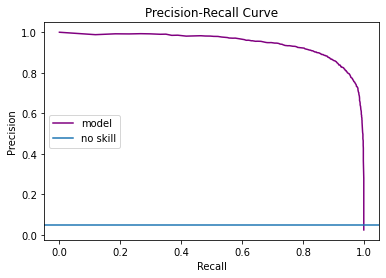

In [23]:
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple', label = 'model')
ax.axhline(y=0.05, label='no skill')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.legend(loc="best")
plt.savefig('precision-recall_curve.png')
plt.show()


c:\Users\pierr\.conda\envs\imbalanced_learn\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


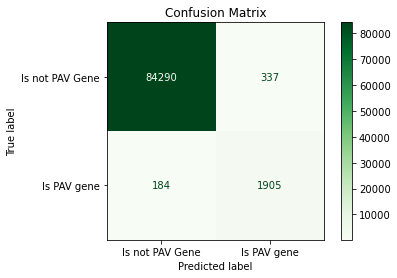

In [27]:
fig = plot_confusion_matrix(model, X_test, y_test, display_labels=['Is not PAV Gene', 'Is PAV gene'], cmap='Greens')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()